In [12]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D,Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from keras.models import Model


# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import cv2
import seaborn as sns

import itertools
import warnings
warnings.filterwarnings('ignore')

**Loading data using paths and data reading**

In [2]:

tr_data = r"../input/100-bird-species/train"
test_data = r"../input/100-bird-species/test"
valid_data = r"../input/100-bird-species/valid"

In [3]:
num_of_bird_groups_train = len(os.listdir(tr_data))
print("Train has ",num_of_bird_groups_train,"different birds")
num_of_bird_groups_valid = len(os.listdir(valid_data))
print("Valid has ",num_of_bird_groups_valid,"different birds")
num_of_bird_groups_test = len(os.listdir(test_data))
print("Test has ",num_of_bird_groups_test,"different birds")

Train has  525 different birds
Valid has  525 different birds
Test has  525 different birds


> This indicates that there are 525 different bird groups in each of the training, validation, and test datasets.

In [4]:

sets=["train","valid","test"]

# Initialize empty dictionaries to store the number of images in each category for each set
train_images_length = {}
test_images_length = {}
valid_images_length = {}

# Iterate through each set
for j in sets:
    # Get the list of categories for the current set
    image_categories = os.listdir(r"../input/100-bird-species/"+j)
    
    # Iterate through each category for the current set
    for i, cat in enumerate(image_categories):
        
        # Define the path to the images for the current category
        image_path = r"../input/100-bird-species/" + j + '/' + cat
        
        # Get the list of images in the current folder
        images_in_folder = os.listdir(image_path)
        
        # Store the number of images in the current category for the current set
        if j == "train":
            train_images_length[cat]=len(images_in_folder)
        elif j == "test":
            test_images_length[cat]=len(images_in_folder)
        elif j == "valid":
            valid_images_length[cat]=len(images_in_folder)

# Create dataframes from the dictionaries
train_df=pd.DataFrame(train_images_length,index = ['count']).T
test_df=pd.DataFrame(test_images_length,index = ['count']).T
valid_df=pd.DataFrame(valid_images_length,index = ['count']).T

In [6]:
print(train_df)

                         count
DALMATIAN PELICAN          159
BLACK BREASTED PUFFBIRD    172
WATTLED CURASSOW           138
AMERICAN WIGEON            187
CARMINE BEE-EATER          162
...                        ...
EUROPEAN GOLDFINCH         135
AMERICAN REDSTART          139
CRANE HAWK                 135
NORTHERN RED BISHOP        130
GOLDEN EAGLE               158

[525 rows x 1 columns]


In [26]:
print(test_df)

                         count
DALMATIAN PELICAN            5
BLACK BREASTED PUFFBIRD      5
WATTLED CURASSOW             5
AMERICAN WIGEON              5
CARMINE BEE-EATER            5
...                        ...
EUROPEAN GOLDFINCH           5
AMERICAN REDSTART            5
CRANE HAWK                   5
NORTHERN RED BISHOP          5
GOLDEN EAGLE                 5

[525 rows x 1 columns]


In [27]:
print(valid_df)

                         count
DALMATIAN PELICAN            5
BLACK BREASTED PUFFBIRD      5
WATTLED CURASSOW             5
AMERICAN WIGEON              5
CARMINE BEE-EATER            5
...                        ...
EUROPEAN GOLDFINCH           5
AMERICAN REDSTART            5
CRANE HAWK                   5
NORTHERN RED BISHOP          5
GOLDEN EAGLE                 5

[525 rows x 1 columns]


Training dataset is having approximately 150 images of each species, whereas the test and valid datasets are hhaving 5 images of each species

In [4]:
#Train_data
print("Train data: ")
train_gen=ImageDataGenerator(rescale=1.0/255).flow_from_directory(tr_data,
                                                                  target_size=(224,224),
                                                                  batch_size=64,
                                                                  shuffle=True,
                                                                  class_mode='categorical')
#test_data
print("Test data:")
test_gen=ImageDataGenerator(rescale=1.0/255).flow_from_directory(test_data,
                                                                target_size=(224,224),
                                                                batch_size=64,
                                                                 shuffle=False,
                                                                class_mode='categorical')
#Valid_data
print("Valid data: ")
valid_gen=ImageDataGenerator(rescale=1.0/255).flow_from_directory(valid_data,
                                                                target_size=(224,224),
                                                                batch_size=64,
                                                                shuffle=False , 
                                                                class_mode='categorical')
    

Train data: 
Found 84635 images belonging to 525 classes.
Test data:
Found 2625 images belonging to 525 classes.
Valid data: 
Found 2625 images belonging to 525 classes.


Dataset is balanced

In [5]:
#Files and Class labels
train_files = train_gen.filepaths
train_labels = train_gen.classes
class_name = list(train_gen.class_indices.keys())

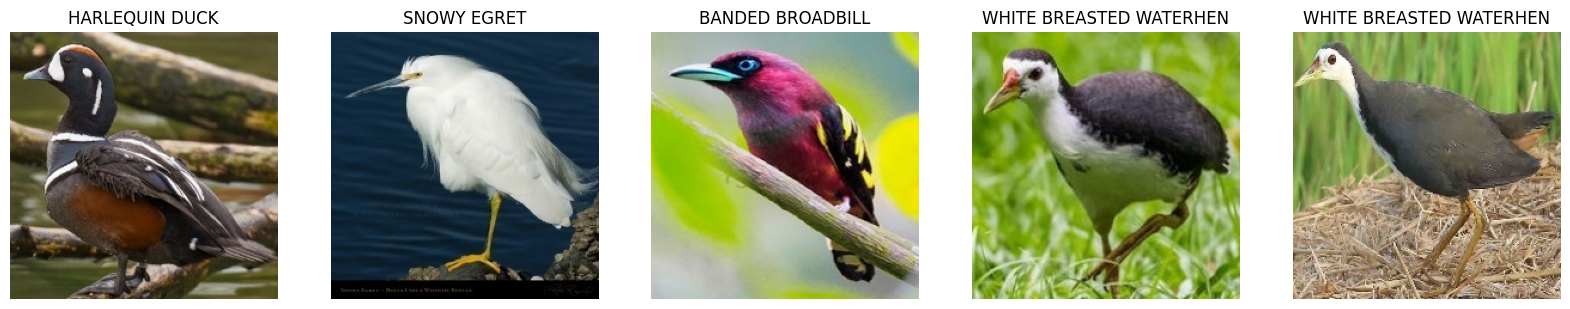

In [30]:
#Getting some random images
sample_images = random.sample(range(len(train_files)),5)
for i in range(0,5):
    plt.rcParams['figure.figsize'] = (20, 30)
    img = plt.imread(train_files[sample_images[i]])
    plt.subplot(5, 5, i+1)
    plt.title(class_name[train_labels[sample_images[i]]])
    plt.imshow(img)
    plt.axis('off')

plt.show()

Plotted 5 randomly selected images with the species they belong to

In [31]:
#Name of first sample image
class_name[train_labels[sample_images[0]]]

'HARLEQUIN DUCK'

In [6]:
#Validation data
validation_files = valid_gen.filepaths
validation_labels = valid_gen.classes
vclass_name = list(valid_gen.class_indices.keys())

In [7]:
#Test data
test_files = test_gen.filepaths
test_labels = test_gen.classes
testclass_name = list(test_gen.class_indices.keys())

In [9]:
#Mapping class labels
class_label=dict([(v,k) for k,v in train_gen.class_indices.items()])

print(class_label)

{0: 'ABBOTTS BABBLER', 1: 'ABBOTTS BOOBY', 2: 'ABYSSINIAN GROUND HORNBILL', 3: 'AFRICAN CROWNED CRANE', 4: 'AFRICAN EMERALD CUCKOO', 5: 'AFRICAN FIREFINCH', 6: 'AFRICAN OYSTER CATCHER', 7: 'AFRICAN PIED HORNBILL', 8: 'AFRICAN PYGMY GOOSE', 9: 'ALBATROSS', 10: 'ALBERTS TOWHEE', 11: 'ALEXANDRINE PARAKEET', 12: 'ALPINE CHOUGH', 13: 'ALTAMIRA YELLOWTHROAT', 14: 'AMERICAN AVOCET', 15: 'AMERICAN BITTERN', 16: 'AMERICAN COOT', 17: 'AMERICAN DIPPER', 18: 'AMERICAN FLAMINGO', 19: 'AMERICAN GOLDFINCH', 20: 'AMERICAN KESTREL', 21: 'AMERICAN PIPIT', 22: 'AMERICAN REDSTART', 23: 'AMERICAN ROBIN', 24: 'AMERICAN WIGEON', 25: 'AMETHYST WOODSTAR', 26: 'ANDEAN GOOSE', 27: 'ANDEAN LAPWING', 28: 'ANDEAN SISKIN', 29: 'ANHINGA', 30: 'ANIANIAU', 31: 'ANNAS HUMMINGBIRD', 32: 'ANTBIRD', 33: 'ANTILLEAN EUPHONIA', 34: 'APAPANE', 35: 'APOSTLEBIRD', 36: 'ARARIPE MANAKIN', 37: 'ASHY STORM PETREL', 38: 'ASHY THRUSHBIRD', 39: 'ASIAN CRESTED IBIS', 40: 'ASIAN DOLLARD BIRD', 41: 'ASIAN GREEN BEE EATER', 42: 'ASIAN OPEN

**Basic CNN model**

In [94]:


# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to feed into densely connected layers
model.add(Flatten())

# Dense layers for classification
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(525, activation='softmax'))  # Assuming 10 classes of birds

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_188 (Conv2D)             │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_189 (Conv2D)             │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_190 (Conv2D)             │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_191 (Conv2D)             │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 525)            │       134,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,944,781 (37.94 MB)

 Trainable params: 9,944,781 (37.94 MB)

 Non-trainable params: 0 (0.00 B)

The model is built using the Keras Sequential API, indicating a linear stack of layers.

The first layer is a 2D convolutional layer (Conv2D) with 32 filters, each with a 3x3 kernel size. It uses the ReLU activation function.

Following the convolutional layer, a max-pooling layer (MaxPooling2D) is added with a 2x2 pool size, reducing the spatial dimensions by half.

This pattern is repeated with subsequent convolutional layers, each with increasing filter size (64, 128, and 128).

After each convolutional layer, there is a corresponding max-pooling layer to down-sample the feature maps.

The Flatten layer is added to convert the 3D feature maps into a 1D vector, which will be fed into the densely connected layers.

Three densely connected layers (Dense) follow the flatten layer. The first two dense layers have 512 and 256 neurons, respectively, using ReLU activation.

The output layer is a dense layer with 525 neurons, representing the assumed 525 classes of birds. It uses the softmax activation function, suitable for multi-class classification.

The model is compiled with the Adam optimizer and categorical cross-entropy loss, commonly used for multi-class classification tasks.

The model summary displays layer types, output shapes, and the number of parameters for each layer. Parameters represent the weights and biases of the layers.

The total number of parameters in the model is 9,944,781, with all parameters being trainable

The model consists of a series of convolutional and max-pooling layers for feature extraction, followed by densely connected layers for classification.

With a total of 9,944,781 parameters, the model is designed for multi-class bird classification, employing the softmax activation function for the output layer.

In [95]:
import tensorflow.keras.callbacks as callbacks
early_stopping = callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

# Defining optimizer with learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(train_gen, epochs=20, verbose=1, 
                    validation_data=valid_gen, 
                    steps_per_epoch=800, 
                    validation_steps=300, 
          callbacks=[early_stopping])
                  

Epoch 1/20


2024-05-15 13:18:15.118015: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 7.51517, expected 6.61089
2024-05-15 13:18:15.118073: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 7.9143, expected 7.01001
2024-05-15 13:18:15.118082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 5.72555, expected 4.82127
2024-05-15 13:18:15.118090: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 7.36992, expected 6.46564
2024-05-15 13:18:15.118098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 7.59363, expected 6.68934
2024-05-15 13:18:15.118106: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 7.26544, expected 6.36115
2024-05-15 13:18:15.118113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 38: 7.08479, expected 6.18051
2024-05-15 13:18:15.118122: E external/local_xla/xl

800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.0178 - loss: 5.9875

2024-05-15 13:20:40.684649: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147863: 4.14435, expected 3.59734
2024-05-15 13:20:40.684705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148032: 3.73171, expected 3.1847
2024-05-15 13:20:40.684720: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148049: 4.2981, expected 3.75109
2024-05-15 13:20:40.684746: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149297: 4.2275, expected 3.68049
2024-05-15 13:20:40.684758: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149362: 3.89754, expected 3.35053
2024-05-15 13:20:40.684770: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149444: 4.35104, expected 3.80403
2024-05-15 13:20:40.684780: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149482: 4.25819, expected 3.71118
2024-05-15 13:20:40.684

800/800 ━━━━━━━━━━━━━━━━━━━━ 151s 171ms/step - accuracy: 0.0178 - loss: 5.9869 - val_accuracy: 0.1375 - val_loss: 4.4505
Epoch 2/20
 62/800 ━━━━━━━━━━━━━━━━━━━━ 1:52 152ms/step - accuracy: 0.1323 - loss: 4.5320

2024-05-15 13:20:51.648572: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 6.15136, expected 5.43494
2024-05-15 13:20:51.648631: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 366: 5.89632, expected 5.1799
2024-05-15 13:20:51.648645: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1288: 5.9205, expected 5.20407
2024-05-15 13:20:51.648653: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1510: 5.4086, expected 4.69218
2024-05-15 13:20:51.648666: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2893: 6.0729, expected 5.35648
2024-05-15 13:20:51.648674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2970: 6.02026, expected 5.30384
2024-05-15 13:20:51.648685: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3678: 6.03727, expected 5.32085
2024-05-15 13:20:51.648694: E external/lo

800/800 ━━━━━━━━━━━━━━━━━━━━ 101s 126ms/step - accuracy: 0.1628 - loss: 4.3147 - val_accuracy: 0.2442 - val_loss: 3.7759
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 137s 170ms/step - accuracy: 0.2592 - loss: 3.6750 - val_accuracy: 0.3341 - val_loss: 3.1944
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 92s 115ms/step - accuracy: 0.3527 - loss: 3.0921 - val_accuracy: 0.3810 - val_loss: 2.9708
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 139s 173ms/step - accuracy: 0.4173 - loss: 2.7502 - val_accuracy: 0.4286 - val_loss: 2.6573
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 91s 113ms/step - accuracy: 0.4939 - loss: 2.3288 - val_accuracy: 0.4598 - val_loss: 2.5465
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 138s 171ms/step - accuracy: 0.5463 - loss: 2.0683 - val_accuracy: 0.4888 - val_loss: 2.3460
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 88s 110ms/step - accuracy: 0.6067 - loss: 1.7625 - val_accuracy: 0.5013 - val_loss: 2.3245
Epoch 9/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 134s 166ms/step - accuracy: 0.6529 - loss: 1.5471 

The model's performance improved over epochs as evidenced by increasing training and validation accuracy.

Reductions in both training and validation losses indicate that the model is learning to generalize better to unseen data.

The training time per epoch varies, with longer durations observed for some epochs, possibly due to fluctuations in the complexity of data or computational resources.

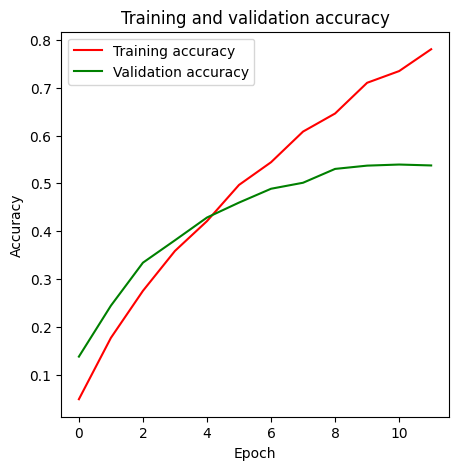

In [96]:
#Plotting accuracy
acc_train = hist.history['accuracy']
acc_val = hist.history['val_accuracy']
plt.figure(figsize=(5,5))
plt.plot(acc_train,label="Training accuracy",color="red")
plt.plot(acc_val,label="Validation accuracy",color="green")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [97]:
#Classification report
test_predictions = model.predict(test_gen)
test_acc = accuracy_score(test_labels, np.argmax(test_predictions, axis=1))

print(f'Test accuracy: {test_acc:.2%}')
test_pred_labels = np.argmax(test_predictions, axis=1)

report = classification_report(test_labels, test_pred_labels)
print(report)

42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step
Test accuracy: 55.28%
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.00      0.00      0.00         5
           2       0.67      0.40      0.50         5
           3       0.57      0.80      0.67         5
           4       1.00      0.60      0.75         5
           5       0.50      0.20      0.29         5
           6       0.60      0.60      0.60         5
           7       0.20      0.40      0.27         5
           8       0.50      0.80      0.62         5
           9       0.30      0.60      0.40         5
          10       0.43      0.60      0.50         5
          11       1.00      0.60      0.75         5
          12       0.50      0.20      0.29         5
          13       0.67      0.40      0.50         5
          14       0.67      0.80      0.73         5
          15       0.57      0.80      0.67         5
          16     

The overall accuracy of the model is 55%, indicates that it correctly classifies 55% of the samples in the dataset.

The macro average precision, recall, and F1-score are 0.60, 0.55, and 0.54, respectively. Suggests that the model's performance across all classes is moderate.

**Transfer Learning**

In [11]:
#transfer learning model and freezing all layers
res_model=InceptionV3(include_top = False,
                         pooling = 'avg',
                         weights = "imagenet",
                         input_shape=(224, 224, 3))
for layer in res_model.layers:
    layer.trainable = False
pre_model = Sequential()
pre_model.add(res_model)
pre_model.add(Flatten())
pre_model.add(Dense(525, activation = 'softmax'))
pre_model.compile(loss = 'categorical_crossentropy', 
                     optimizer='adam', 
                     metrics=['accuracy'])
# Define a callback to save the model during training
checkpoint_callback = ModelCheckpoint('inceptionV3_model.keras', 
                                      monitor="val_loss", 
                                      verbose=1, 
                                      save_best_only=True, 
                                      mode='min')
history=pre_model.fit(train_gen,steps_per_epoch=700,batch_size= 64, validation_data=valid_gen, epochs=5,callbacks=[checkpoint_callback])

Epoch 1/5
  2/700 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.0039 - loss: 6.6177       

I0000 00:00:1715834448.153968     165 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715834448.210471     165 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.3618 - loss: 3.3693

W0000 00:00:1715834950.484678     164 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.10562, saving model to inceptionV3_model.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 561s 761ms/step - accuracy: 0.3620 - loss: 3.3676 - val_accuracy: 0.7055 - val_loss: 1.1056
Epoch 2/5
623/700 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - accuracy: 0.7167 - loss: 1.1115
Epoch 2: val_loss improved from 1.10562 to 0.88345, saving model to inceptionV3_model.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 224s 320ms/step - accuracy: 0.7176 - loss: 1.1074 - val_accuracy: 0.7630 - val_loss: 0.8834
Epoch 3/5
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7770 - loss: 0.8557
Epoch 3: val_loss improved from 0.88345 to 0.74961, saving model to inceptionV3_model.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 195s 276ms/step - accuracy: 0.7770 - loss: 0.8557 - val_accuracy: 0.8000 - val_loss: 0.7496
Epoch 4/5
623/700 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.8120 - loss: 0.7146
Epoch 4: val_loss improved from 0.74961 to 0.72819, saving model to inceptionV3_model.keras
700/700 ━

Utilized InceptionV3 model with freezinng all layers and the model has achieved significant accuracy in training and validation over the epochs.
Yet the number of epochs given are small the model has improved its performance in first 2 epochs.
The best model has saved at last epoch as the model has constantly increasing its performance over epochs

In [12]:
#Saving model
pre_model.save('inceptionV3_model.keras')

In [20]:
#import os

#os.environ['KAGGLE_CONFIG_DIR'] = '/root/'
#import kaggle

OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

In [19]:
#import kaggle
#from kaggle.api.kaggle_api_extended import KaggleApi

#api = KaggleApi()
#api.authenticate()
#api.dataset_download_file('/kaggle/working/inceptionV3_model.keras', path=r'C:\Users\Downloads',unzip=True)

OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

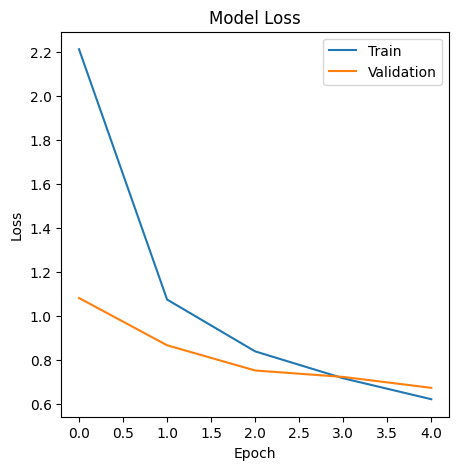

In [87]:
# Plot training loss
plt.figure(figsize=(5,5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Loss was constantly decreasing over the epochs indicating that the model has increased its performance and minimized its error.

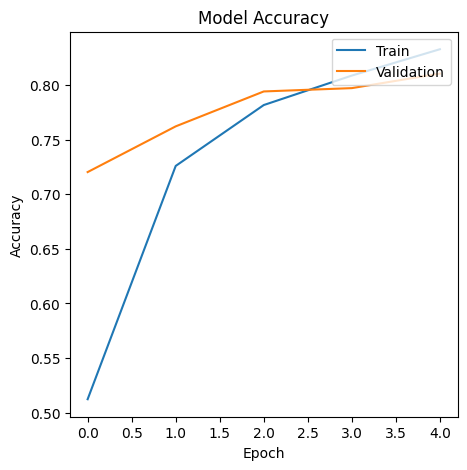

In [88]:
# Plot training accuracy
plt.figure(figsize=(5,5))

plt.plot(pre_model.history.history['accuracy'])
plt.plot(pre_model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The training accuracy curve is in increasing trend over epochs, indicating that the model is learning from the training data.

In [93]:
# Evaluate the model on test data
test_loss, test_accuracy = pre_model.evaluate(test_gen, steps=len(test_gen))

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')




42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.8314 - loss: 0.5995
Test Loss: 0.5634, Test Accuracy: 0.8476


Model achieved an impressive accuracy of 0.84% which indicates that the model is classifying images well on unseen data

In [62]:
# Confusion matrix
test_gen.reset()  # Reset the generator to start at the beginning of the dataset
predictions = pre_model.predict(test_gen, steps=len(test_gen))

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Extract confusion matrix for the first 10 classes
cm_first_10 = cm[:10, :10]

print("Confusion matrix for the first 10 classes:")
print(cm_first_10)

 1/42 ━━━━━━━━━━━━━━━━━━━━ 3:58 6s/step

W0000 00:00:1715776497.515484     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step
Confusion matrix for the first 10 classes:
[[4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


In [63]:
#Classification report
test_predictions = pre_model.predict(test_gen)
class_labels = list(test_gen.class_indices.keys())
test_pred_labels = np.argmax(test_predictions, axis=1)
# Generate classification report
report = classification_report(test_labels, test_pred_labels, target_names=class_labels)

# Print classification report
print(report)

42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step
                               precision    recall  f1-score   support

              ABBOTTS BABBLER       1.00      0.80      0.89         5
                ABBOTTS BOOBY       0.00      0.00      0.00         5
   ABYSSINIAN GROUND HORNBILL       1.00      0.80      0.89         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       0.80      0.80      0.80         5
            AFRICAN FIREFINCH       0.80      0.80      0.80         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      0.80      0.89         5
          AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                    ALBATROSS       1.00      1.00      1.00         5
               ALBERTS TOWHEE       1.00      1.00      1.00         5
         ALEXANDRINE PARAKEET       0.62      1.00      0.77         5
                ALPINE CHOUGH      

The overall accuracy of the model is 86%, indicates that it correctly classifies 86% of the samples in the dataset.

The macro average precision, recall, and F1-score are 0.89, 0.86, and 0.85, respectively. Suggests that the model's performance across all classes is very impressive.

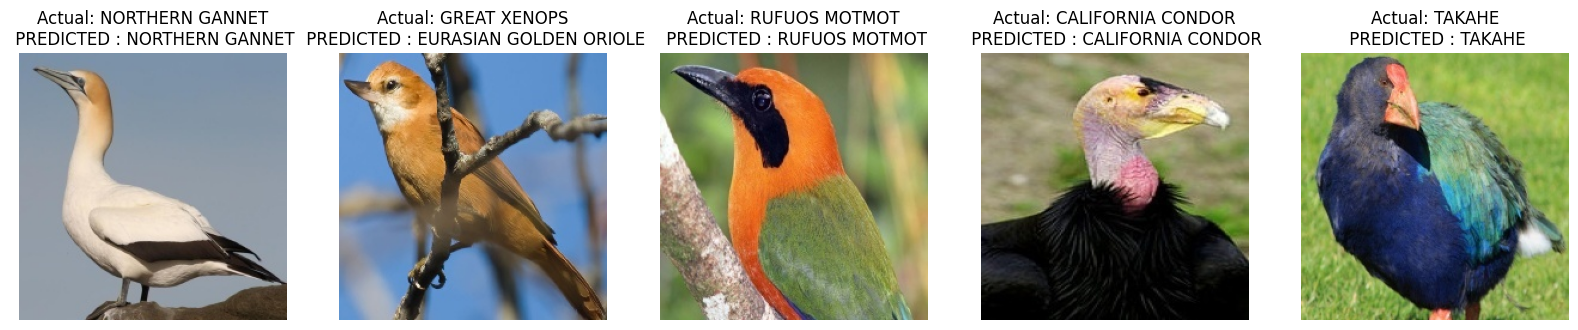

In [73]:
#Testing images
sample_images = random.sample(range(len(test_files)),5)
for i in range(0,5):
    plt.rcParams['figure.figsize'] = (20, 30)
    img = plt.imread(test_files[sample_images[i]])
    plt.subplot(5, 5, i+1)
    pred_label = np.argmax(test_predictions[sample_images[i]])
    plt.title(f"Actual: {class_name[test_labels[sample_images[i]]]}\n PREDICTED : {class_labels[pred_label]}")
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [10]:
#transfer learning model and freezing only last  layers
model1=InceptionV3(include_top = False,
                         weights = "imagenet",
                         input_shape=(224, 224, 3))
for layer in model1.layers:
    layer.trainable = False
    
for layer in model1.layers[-10:]:
    layer.trainable=True
#Adding last layers
x=model1.output
x=GlobalAveragePooling2D()(x)
x=Dense(128,activation="relu")(x)
x=Dropout(0.3)(x)
prediction = Dense(525,activation="softmax")(x)

In [17]:
import tensorflow.keras.callbacks as callbacks
model_incept=Model(inputs=model1.input, outputs=prediction)
early_stopping = callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

# Defining optimizer with learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model_incept.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint_callback1 = ModelCheckpoint('inceptionV3_model2.keras', 
                                      monitor="val_loss", 
                                      verbose=1, 
                                      save_best_only=True,
                                     mode="min")

hist1 = model_incept.fit(train_gen, epochs=20, verbose=1, 
                    validation_data=valid_gen, 
                    steps_per_epoch=800, 
                    validation_steps=300, 
                    callbacks=checkpoint_callback1)


Epoch 1/20
  2/800 ━━━━━━━━━━━━━━━━━━━━ 1:03 80ms/step - accuracy: 0.0000e+00 - loss: 6.4219  

I0000 00:00:1715875316.628121     224 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715875316.686718     224 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.0340 - loss: 5.8859

W0000 00:00:1715875747.437873     227 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 3.86963, saving model to inceptionV3_model2.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 488s 576ms/step - accuracy: 0.0340 - loss: 5.8853 - val_accuracy: 0.2808 - val_loss: 3.8696
Epoch 2/20
523/800 ━━━━━━━━━━━━━━━━━━━━ 1:31 330ms/step - accuracy: 0.1736 - loss: 4.0523
Epoch 2: val_loss improved from 3.86963 to 3.05415, saving model to inceptionV3_model2.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 180s 225ms/step - accuracy: 0.1805 - loss: 3.9929 - val_accuracy: 0.3924 - val_loss: 3.0542
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.2482 - loss: 3.4154
Epoch 3: val_loss improved from 3.05415 to 2.43525, saving model to inceptionV3_model2.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 212s 263ms/step - accuracy: 0.2482 - loss: 3.4153 - val_accuracy: 0.5048 - val_loss: 2.4353
Epoch 4/20
523/800 ━━━━━━━━━━━━━━━━━━━━ 55s 199ms/step - accuracy: 0.3125 - loss: 2.9618
Epoch 4: val_loss improved from 2.43525 to 2.16543, saving model to inceptionV3_model2.keras
8

In [ ]:
model_incept.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,793,161 (86.95 MB)

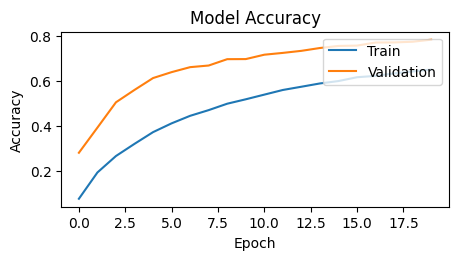

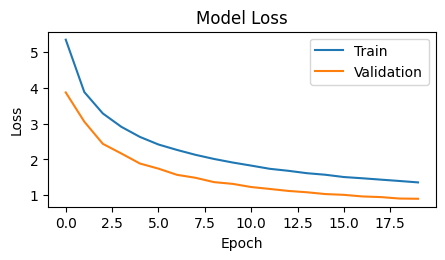

In [34]:
# Plot training accuracy
plt.figure(figsize=(5,5))
plt.subplot(211)
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
# Plot training accuracy
plt.figure(figsize=(5,5))
plt.subplot(212)
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.show()

In [29]:
#Classification report
test_predictions1 = model_incept.predict(test_gen)
class_labels = list(test_gen.class_indices.keys())
test_pred_labels = np.argmax(test_predictions1, axis=1)
# Generate classification report
report = classification_report(test_labels, test_pred_labels, target_names=class_labels)

# Print classification report
print(report)

 1/42 ━━━━━━━━━━━━━━━━━━━━ 4:22 6s/step

W0000 00:00:1715880861.195831     225 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 739ms/step
                               precision    recall  f1-score   support

              ABBOTTS BABBLER       0.60      0.60      0.60         5
                ABBOTTS BOOBY       0.50      0.20      0.29         5
   ABYSSINIAN GROUND HORNBILL       0.83      1.00      0.91         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       1.00      0.80      0.89         5
            AFRICAN FIREFINCH       0.57      0.80      0.67         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       0.80      0.80      0.80         5
          AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                    ALBATROSS       0.83      1.00      0.91         5
               ALBERTS TOWHEE       1.00      1.00      1.00         5
         ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
                ALPINE CHOUGH     

The model achieved an accuracy of 81% on the test dataset, indicating its ability to correctly classify bird species. This metric provides a general overview of the model's performance.

The macro average F1-score of 0.81 suggests relatively balanced performance across different bird species classes

The weighted average F1-score of 0.80 indicates the model's overall performance

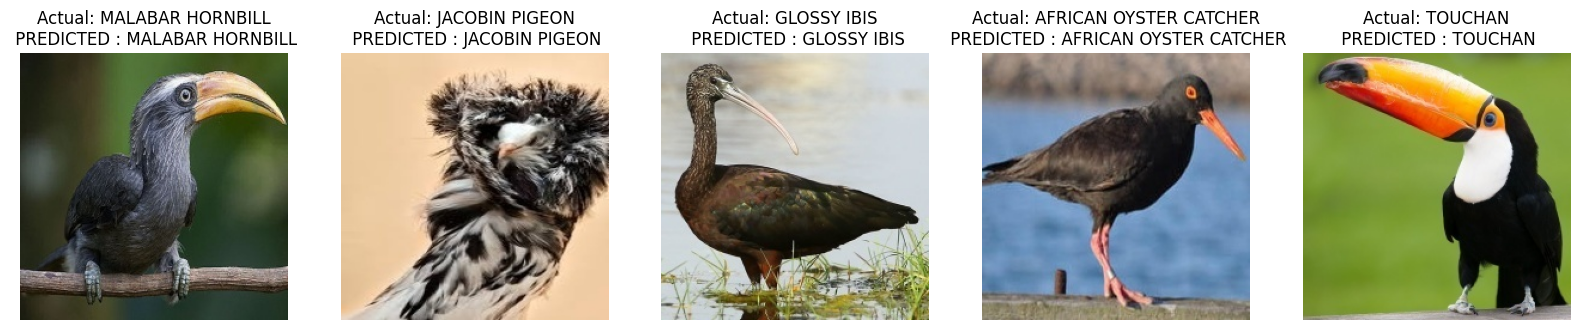

In [31]:
#Testing images
sample_images = random.sample(range(len(test_files)),5)
for i in range(0,5):
    plt.rcParams['figure.figsize'] = (20, 30)
    img = plt.imread(test_files[sample_images[i]])
    plt.subplot(5, 5, i+1)
    pred_label = np.argmax(test_predictions1[sample_images[i]])
    plt.title(f"Actual: {class_name[test_labels[sample_images[i]]]}\n PREDICTED : {class_labels[pred_label]}")
    plt.imshow(img)
    plt.axis('off')

plt.show()